<a href="https://colab.research.google.com/github/RehmaRizvi/IMAGE_SEGMENTATION/blob/main/pet_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
import pandas as pd
from tensorflow.keras import layers



In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteNI28OJ/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteNI28OJ/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


**PREPROCESSING**

In [ ]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

In [ ]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [ ]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

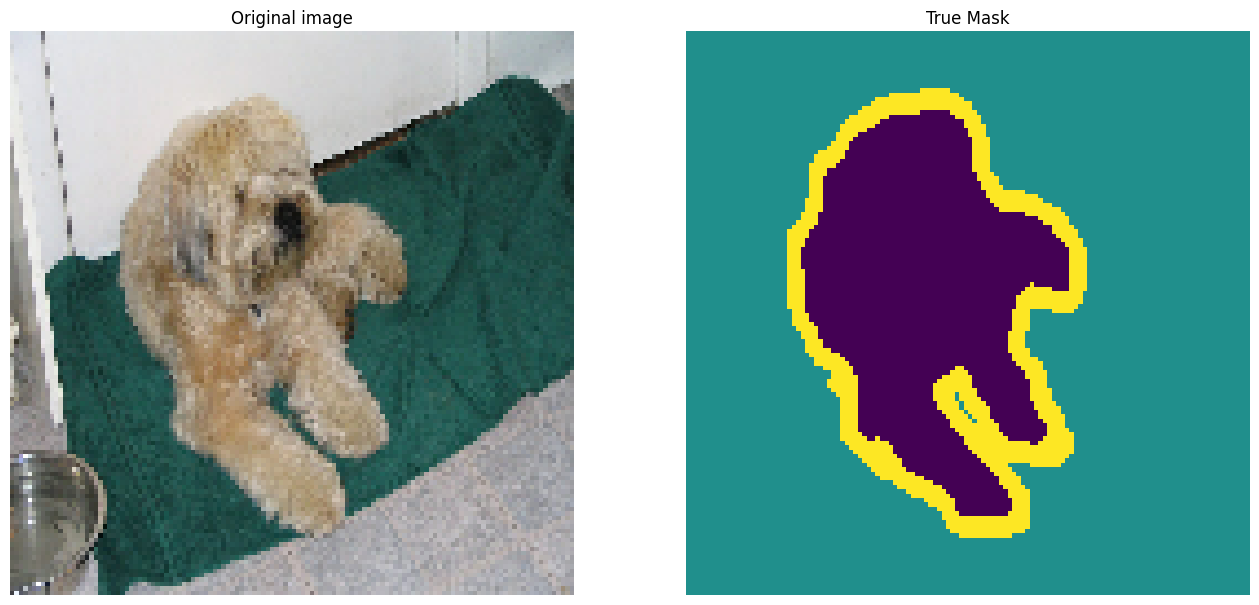

In [ ]:
def display(display_list):
 plt.figure(figsize=(16,16))
 title = ["Original image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [ ]:
 def build_unet_model():
   inputs = layers.Input(shape=(128,128,3))
   labels=inputs
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
   jaccard_coef_score = jaccard_coef(labels, outputs)
    # Create the model
   unet_model = tf.keras.Model(inputs=inputs, outputs=[outputs, jaccard_coef_score], name="U-Net")
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [ ]:
def jaccard_coef(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(jaccard)


In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
metrics=["accuracy", jaccard_coef]

In [ ]:
unet_model.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=metrics)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
NUM_EPOCHS = 15
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENGTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches,
                              callbacks=tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True))

# Create a DataFrame from model_history
history_df = pd.DataFrame(model_history.history)

# Define filename
filename = 'model_results.csv'

# Save DataFrame to a CSV file
history_df.to_csv(filename, index=False)




Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 [==============================] - 122s 1s/step - loss: 0.9153 - accuracy: 0.5757 - jaccard_coef: 0.3067 - val_loss: 0.8523 - val_accuracy: 0.5891 - val_jaccard_coef: 0.3086
Epoch 2/15
57/57 [==============================] - 82s 1s/step - loss: 0.7720 - accuracy: 0.6599 - jaccard_coef: 0.3070 - val_loss: 0.6938 - val_accuracy: 0.7232 - val_jaccard_coef: 0.3086
Epoch 3/15
57/57 [==============================] - 68s 1s/step - loss: 0.6892 - accuracy: 0.7172 - jaccard_coef: 0.3067 - val_loss: 0.6476 - val_accuracy: 0.7359 - val_jaccard_coef: 0.3086
Epoch 4/15
57/57 [==============================] - 69s 1s/step - loss: 0.6052 - accuracy: 0.7595 - jaccard_coef: 0.3068 - val_loss: 0.5551 - val_accuracy: 0.7819 - val_jaccard_coef: 0.3086
Epoch 5/15
57/57 [==============================] - 68s 1s/step - loss: 0.5437 - accuracy: 0.7857 - jaccard_coef: 0.3068 - val_loss: 0.5185 - val_accuracy: 0.7962 - val_jaccard_coef: 0.3086
Epoch 6/15
57/57 [==============================] - 68s 1s/s

In [ ]:
# Assuming you have your image data stored in X (input images) and y (corresponding segmentation masks)
input_images = np.array([data[0] for data in train_dataset])
input_masks = np.array([data[1] for data in train_dataset])
X=input_images
y=input_masks

# Initialize the KFold object with the number of folds (k=5)
kfold = KFold(n_splits=5)
cv_scores=[]
num_folds=5

# Iterate over the cross-validation splits
for train_index, test_index in kfold.split(X):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train your segmentation model on the current fold using X_train and y_train
    # Replace the following code with your own model training code
    model = unet_model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Evaluate the model on the test data for the current fold
    score = jaccard_coef(y_test, y_pred)

    # Store the score in the list
    cv_scores.append(score)

# Calculate the mean and standard deviation of the scores
mean_score = sum(cv_scores) / num_folds
std_dev = np.std(cv_scores)

# Print the results
print("Cross-validation scores:", cv_scores)
print("Mean score:", mean_score)
print("Standard deviation:", std_dev)
    # Evaluate your model on the current fold using X_test and y_test
    # Replace the following code with your own model evaluation code
    #evaluation_metrics = model.evaluate(X_test, y_test)

    # Print or store the evaluation metrics for this fold
    #print("Evaluation metrics:", evaluation_metrics)


23/23 [==============================] - 3s 124ms/step
Cross-validation scores: [<tf.Tensor: shape=(), dtype=float32, numpy=0.30754107>, <tf.Tensor: shape=(), dtype=float32, numpy=0.30732447>, <tf.Tensor: shape=(), dtype=float32, numpy=0.3069845>, <tf.Tensor: shape=(), dtype=float32, numpy=0.30739108>, <tf.Tensor: shape=(), dtype=float32, numpy=0.3046678>]
Mean score: tf.Tensor(0.3067818, shape=(), dtype=float32)
Standard deviation: 0.001072594


In [ ]:
from google.colab import files

In [ ]:
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
history_a=model_history

NameError: ignored

In [ ]:
history_df = pd.DataFrame(model_history.history)  #saving the results


NameError: ignored

In [ ]:
history_a.history

NameError: ignored

In [ ]:
test_loss=history_a.history['val_loss']

In [ ]:
val_loss #validation_loss

[0.8355734944343567,
 0.7933689951896667,
 0.6395414471626282,
 0.6309475898742676,
 0.5724185109138489,
 0.4603743255138397,
 0.4927000403404236,
 0.4193101227283478,
 0.37557265162467957,
 0.38227003812789917,
 0.3832062780857086,
 0.3942320644855499]

In [ ]:
filename = 'model_results.csv'


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
def show_predictions(dataset=None, num=1):
  if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 11


2/2 [==============================] - 0s 181ms/step


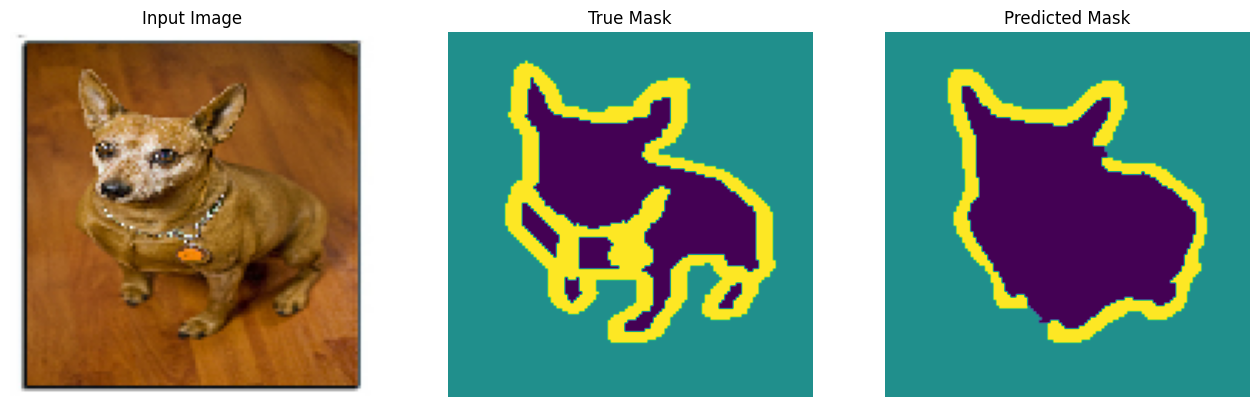

2/2 [==============================] - 0s 116ms/step


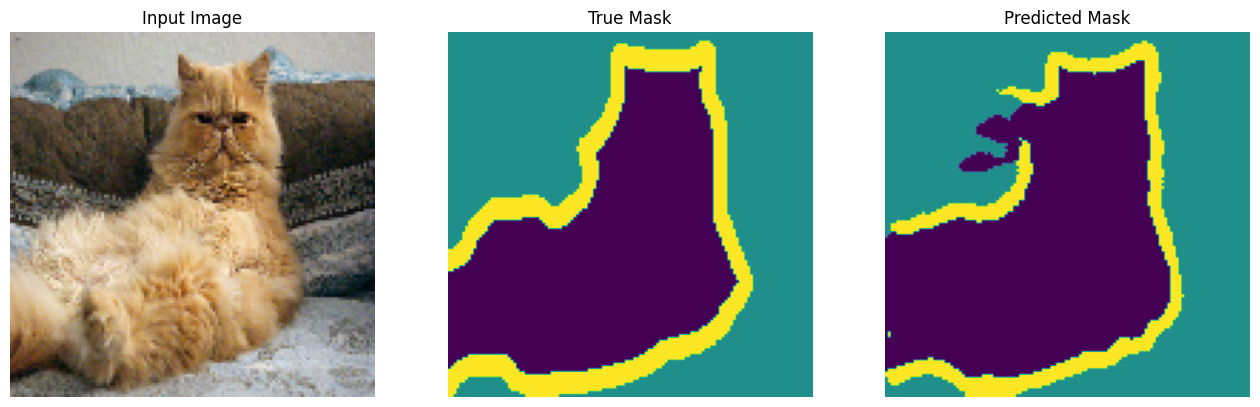

2/2 [==============================] - 0s 116ms/step


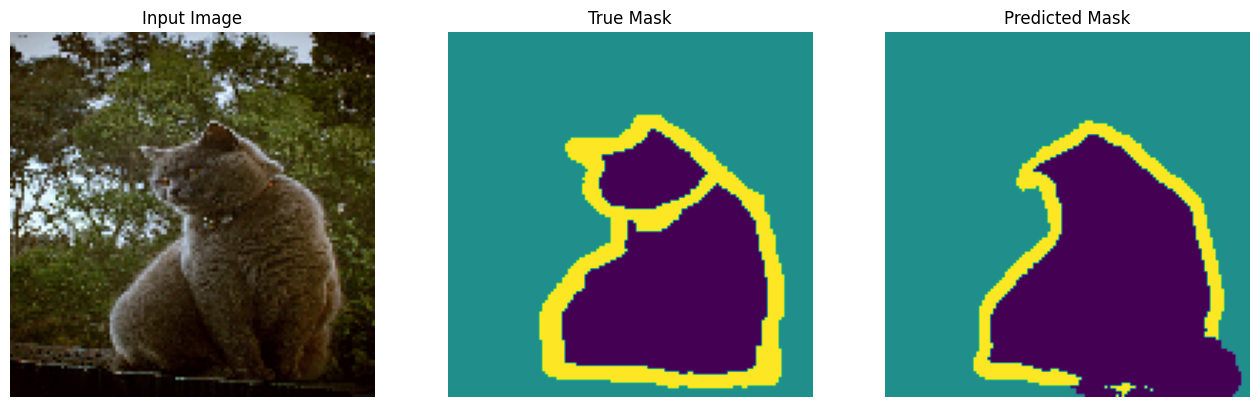

2/2 [==============================] - 0s 115ms/step


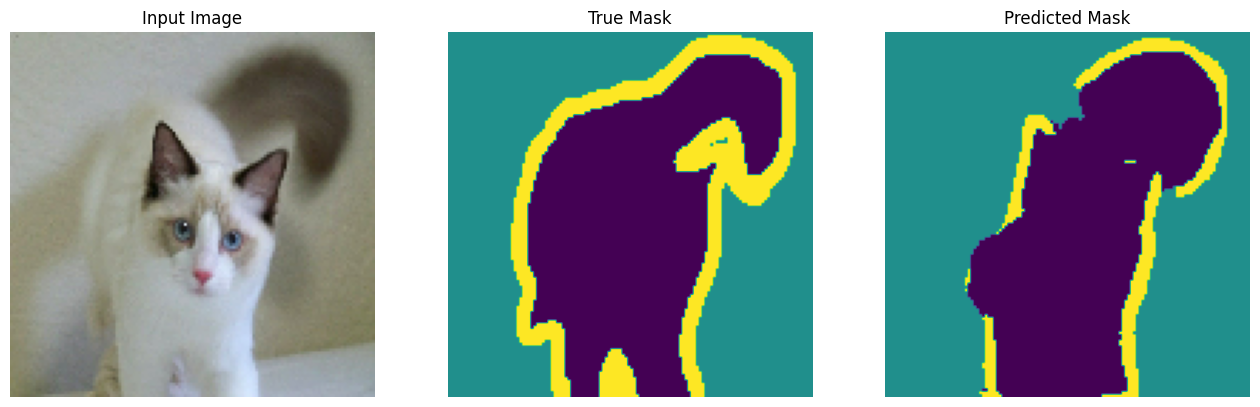

2/2 [==============================] - 0s 120ms/step


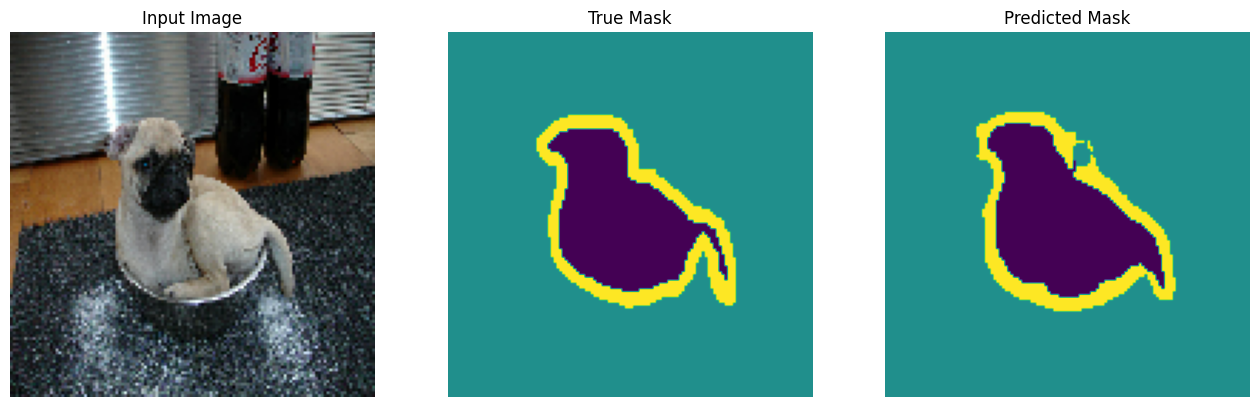

2/2 [==============================] - 0s 116ms/step


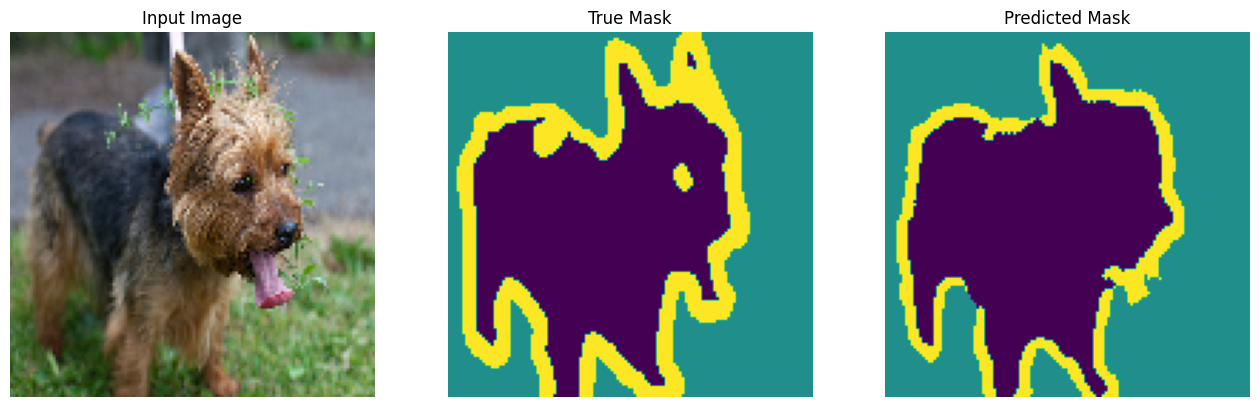

In [ ]:
show_predictions(test_batches, 6 )